<a href="https://colab.research.google.com/github/srRyzhov/Hackathon/blob/main/NLP_Karim2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [140]:
!pip install transformers
!pip install datasets
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 41.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=250561a2fb4580688abced737c195cd8ca301107b46d22302be3b0616a1b2935
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [17]:
import pandas as pd
import numpy as np
import random
import torch
import transformers
import torch.nn as nn
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import load_metric, Dataset
from sklearn.metrics import classification_report, f1_score
import seaborn as sns

In [67]:
train_df = pd.read_excel('/content/CRA_train_1200.xlsx', engine = 'openpyxl', index_col = 0)
test_df = pd.read_excel('/content/CRA_train_1200.xlsx', engine = 'openpyxl', index_col = 0)

In [19]:
train_df

,pr_txt,Категория,Уровень рейтинга
Id,,,
1,Повышение кредитного рейтинга Акционерного об...,A,A
2,«Эксперт РА» подтвердил кредитный рейтинг комп...,BB,BB
3,"НКР повысило кредитный рейтинг ООО ""ОТЭКО-Порт...",A,A
4,«Эксперт РА» присвоил кредитный рейтинг ПАО «Ф...,AAA,AAA
5,29 марта 2023 г. Ведущий рейтинговый аналитик ...,BBB,BBB
...,...,...,...
1207,«Эксперт РА» подтвердил рейтинг компании «Татн...,AAA,AAA
1208,«Эксперт РА» понизил рейтинг компании «Инвестг...,BB,BB
1209,АКРА подтвердило ПАО «КАМАЗ» кредитный рейтинг...,A,A+


<Axes: xlabel='Категория', ylabel='count'>

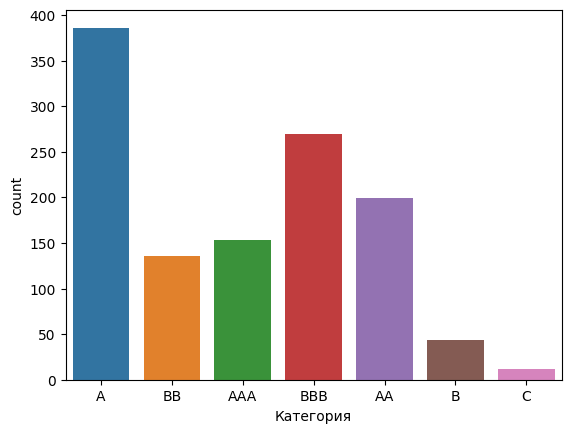

In [20]:
sns.countplot(data=train_df, x="Категория")

<Axes: xlabel='Уровень рейтинга', ylabel='count'>

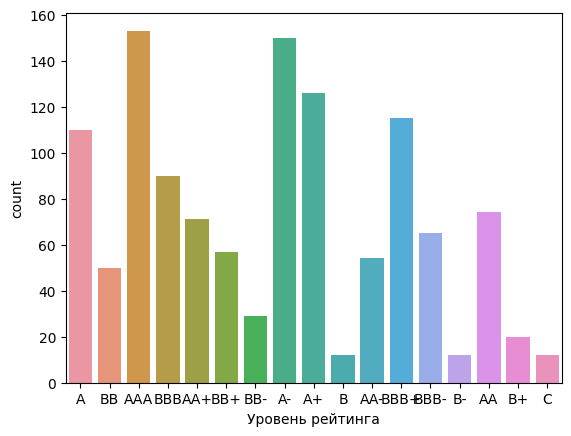

In [21]:
sns.countplot(data=train_df, x="Уровень рейтинга")

In [153]:
train_text = train_df['pr_txt'].astype('str')
train_labels7 = train_df['Категория']
train_labels17 = train_df['Уровень рейтинга']

In [152]:
test_text = train_df['pr_txt'].astype('str')
test_labels7 = train_df['Категория']
test_labels17 = train_df['Уровень рейтинга']

In [154]:
train_text[3]

'НКР повысило кредитный рейтинг ООО "ОТЭКО-Портсервис" \nс <rating> до <rating> со стабильным прогнозом\n31 марта 2023 года\nСтруктура рейтинга\nСтруктура БОСК\nБОСК1\na\n\n\nОСК\na.ru\n\n\nВнешнее влияние\n-\n\n\nКредитный рейтинг\n<rating>\n\n\nПрогноз\nстабильный\n\n\n1 Базовая оценка собственной кредитоспособности\n\nРейтинговое агентство НКР повысило кредитный рейтинг ООО "ОТЭКО-Портсервис" (далее - "ОТЭКО-Портсервис", "компания") с <rating> до <rating> со стабильным прогнозом.\nРезюме\n* Повышение рейтинга обусловлено существенным улучшением оценки финансового профиля компании благодаря росту выручки на фоне увеличения объёмов перевалки и, как следствие, снижения долговой нагрузки в 2022 году и сохранения высоких показателей рентабельности.\n* Оценку бизнес-профиля поддерживает сильная текущая и прогнозируемая конъюнктура энергетического рынка, а также обширная география конечных потребителей.\n* Некоторое снижение оценки бизнес-профиля обусловлено ослаблением устойчивости рынков

In [141]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import pymorphy2
morph = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [192]:
    def delete_stop_words(word_tokens):
      stop_words = list(stopwords.words('russian'))
      new_release = []
      for word in word_tokens:
          if word not in stop_words and word != "\n":
              new_release.append(word)
      return new_release

In [193]:
def form_dict(text):
  for word in text:
    if word not in word_frequencies.keys():
      word_frequencies[word] = 1
    else:
      word_frequencies[word] += 1

In [164]:
train_text1 = train_text.apply(lambda x: re.sub(r"[^а-яА-Я]+"," ",x, flags=re.UNICODE))

In [165]:
train_text1

Id
1       Повышение кредитного рейтинга Акционерного общ...
2        Эксперт РА подтвердил кредитный рейтинг компа...
3       НКР повысило кредитный рейтинг ООО ОТЭКО Портс...
4        Эксперт РА присвоил кредитный рейтинг ПАО Фос...
5        марта г Ведущий рейтинговый аналитик Юрова Ал...
                              ...                        
1207     Эксперт РА подтвердил рейтинг компании Татнеф...
1208     Эксперт РА понизил рейтинг компании Инвестгео...
1209    АКРА подтвердило ПАО КАМАЗ кредитный рейтинг п...
1210    АКРА подтвердило кредитный рейтинг ФГУП Почта ...
1211     Эксперт РА подтвердил рейтинг компании СИБИНТ...
Name: pr_txt, Length: 1200, dtype: object

In [166]:
train_text2 = train_text1.apply(lambda x: nltk.word_tokenize(x,language = "russian"))

In [167]:
train_text2

Id
1       [Повышение, кредитного, рейтинга, Акционерного...
2       [Эксперт, РА, подтвердил, кредитный, рейтинг, ...
3       [НКР, повысило, кредитный, рейтинг, ООО, ОТЭКО...
4       [Эксперт, РА, присвоил, кредитный, рейтинг, ПА...
5       [марта, г, Ведущий, рейтинговый, аналитик, Юро...
                              ...                        
1207    [Эксперт, РА, подтвердил, рейтинг, компании, Т...
1208    [Эксперт, РА, понизил, рейтинг, компании, Инве...
1209    [АКРА, подтвердило, ПАО, КАМАЗ, кредитный, рей...
1210    [АКРА, подтвердило, кредитный, рейтинг, ФГУП, ...
1211    [Эксперт, РА, подтвердил, рейтинг, компании, С...
Name: pr_txt, Length: 1200, dtype: object

In [173]:
train_text3 = train_text2.apply(lambda x: [morph.parse(word)[0].normal_form for word in x])

In [175]:
train_text3[1][5]

'уральский'

In [187]:
#train_text4 = train_text3.apply(lambda x: [morph.parse(word)[0].normal_form for word in x])
train_text4 = train_text3.apply(lambda x: delete_stop_words(x))

In [ ]:
#len(train_text4[2])
train_text4[2]

In [190]:
seq_len_train = [len(i) for i in train_text4]

#seq_len_train = [len(str(i).split()) for i in train_text1]
#seq_len_test = [len(str(i).split()) for i in test_text]
#max_seq_len = max(max(seq_len_test), max(seq_len_train))
#max_seq_len
max(seq_len_train)

1780

In [197]:
word_frequencies = {}
#train_text4.apply(lambda x: form_dict(x))
for x in train_text4: form_dict(x)

In [195]:
train_text4

Id
1       [повышение, кредитный, рейтинг, акционерный, о...
2       [эксперт, ра, подтвердить, кредитный, рейтинг,...
3       [нкр, повысить, кредитный, рейтинг, ооо, отэко...
4       [эксперт, ра, присвоить, кредитный, рейтинг, п...
5       [март, г, ведущий, рейтинговый, аналитик, юров...
                              ...                        
1207    [эксперт, ра, подтвердить, рейтинг, компания, ...
1208    [эксперт, ра, понизить, рейтинг, компания, инв...
1209    [акр, подтвердить, пао, камаз, кредитный, рейт...
1210    [акр, подтвердить, кредитный, рейтинг, фгуп, п...
1211    [эксперт, ра, подтвердить, рейтинг, компания, ...
Name: pr_txt, Length: 1200, dtype: object

In [ ]:
#word_frequencies
sorted_word_frequencies = dict(sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True))
sorted_word_frequencies

BERT

In [218]:
from transformers import BertForSequenceClassification, BertTokenizer

model_name = 'DeepPavlov/rubert-base-cased'
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=7)
tokenizer = BertTokenizer.from_pretrained(model_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [220]:
from transformers import BertForSequenceClassification, BertTokenizer

#Load AutoModel from huggingface model repository
#tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_nlu_ru")
#model = AutoModel.from_pretrained("ai-forever/sbert_large_nlu_ru")

model_name = 'ai-forever/sbert_large_nlu_ru'
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=7)
tokenizer = BertTokenizer.from_pretrained(model_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/sbert_large_nlu_ru and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#model = BertForSequenceClassification.from_pretrained('rubert_base_cased_sentence/', num_labels=2).to("cuda")
#tokenizer = BertTokenizer.from_pretrained('rubert_base_cased_sentence/')

In [24]:
def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
seed_all(42)